In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob

In [ ]:
df = pd.read_csv('cleanDataFINAL_translate.csv')
df

,Clean Tweet
0,coalition of civil society concerned about dis...
1,cc dasco country dares to call it a national d...
2,banda aceh aceh governor muzakir manaf mualem ...
3,"acehnese people, severe flash floods, tsunami ..."
4,emergency bridge built by residents reje linge...
...,...
1067,bdx indonesia indosat strong emergency respons...
1068,minister of social affairs for social assistan...
1069,kemenpu adhi river hand affected by floods in ...
1070,tni orders to optimally clean west sumatra isl...


In [4]:
#textblob
polarity = lambda x: TextBlob(x).sentiment.polarity
df['polarity'] = df['Clean Tweet'].apply(polarity)
def analysis(score):
    if score > 0 :
        return 'positive'
    else:
        return 'negative'
df['Score'] = df['polarity'].apply(analysis)
df.head()
print("Positif :", (sum(df['Score'] =='positive')))
print("Negatif :", (sum(df['Score'] =='negative')))
df

Positif : 387
Negatif : 685


,Clean Tweet,polarity,Score
0,coalition of civil society concerned about dis...,-0.122222,negative
1,cc dasco country dares to call it a national d...,0.000000,negative
2,banda aceh aceh governor muzakir manaf mualem ...,-0.050000,negative
3,"acehnese people, severe flash floods, tsunami ...",0.036905,positive
4,emergency bridge built by residents reje linge...,0.000000,negative
...,...,...,...
1067,bdx indonesia indosat strong emergency respons...,0.391667,positive
1068,minister of social affairs for social assistan...,0.033333,positive
1069,kemenpu adhi river hand affected by floods in ...,0.000000,negative
1070,tni orders to optimally clean west sumatra isl...,0.366667,positive


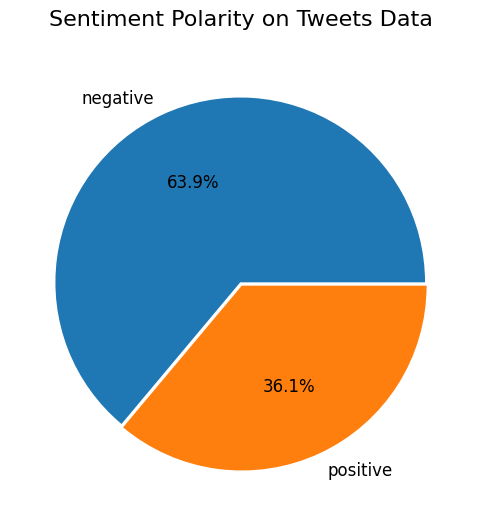

In [5]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in df['Score'].value_counts('positive', 'negative')]
labels = list(df['Score'].value_counts('positive', 'negative').index)
explode = (0.01, 0.01)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 12})
ax.set_title('Sentiment Polarity on Tweets Data', fontsize = 16, pad = 20)
plt.show()

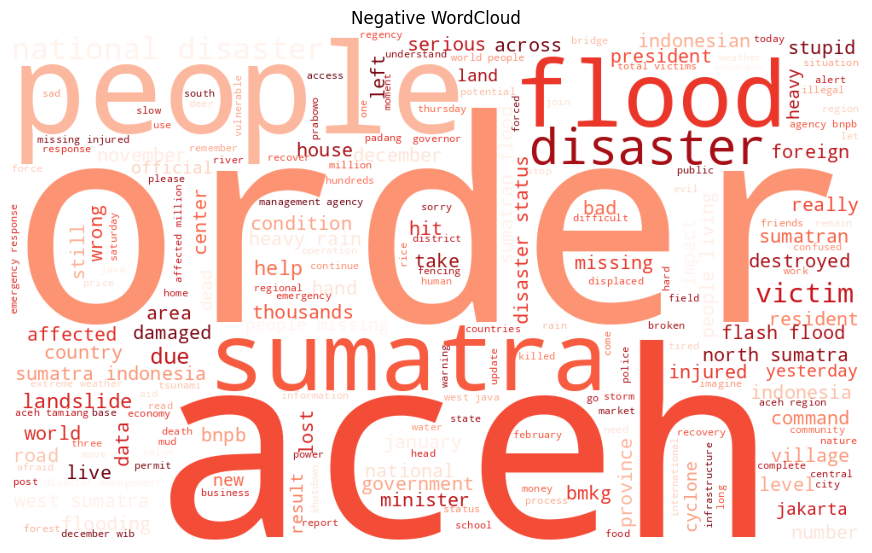

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

negative_words =' '.join([str(text) for text in df['Clean Tweet'][df['polarity'] < 0]])
def wordcloud(data, title = None):
    wordcloud = WordCloud(width = 500, height =300,
        background_color='white',
        stopwords=stopwords,
        max_words=1000,
        max_font_size=200,
        scale=2,
        random_state=3,
        colormap='Reds' # Changed colormap to 'Reds' for a negative wordcloud
).generate(str(data))
    fig = plt.figure(1, figsize=(11,11))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.title('Negative WordCloud')
    plt.show()
wordcloud(negative_words)

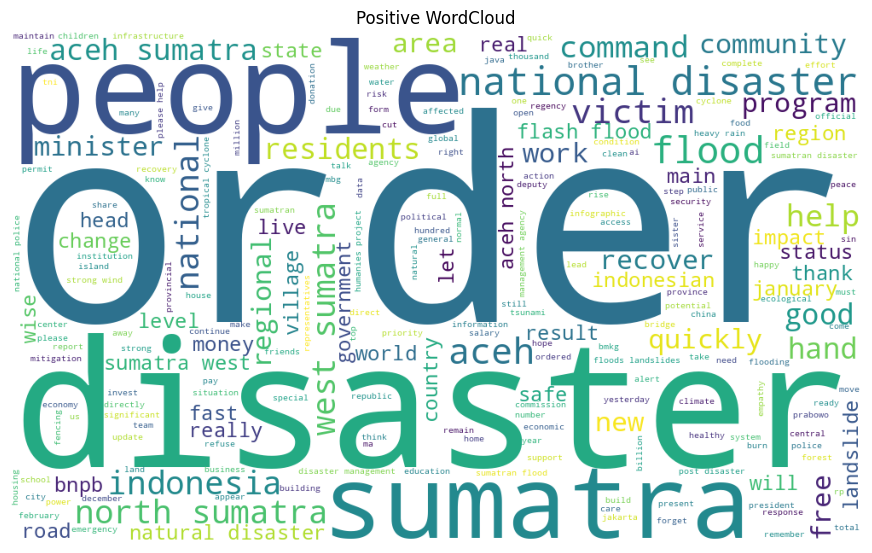

In [7]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

positive_words =' '.join([str(text) for text in df['Clean Tweet'][df['polarity'] > 0]])
def wordcloud(data, title = None):
    wordcloud = WordCloud(width = 500, height =300,
        background_color='white',
        stopwords=stopwords,
        max_words=1000,
        max_font_size=200,
        scale=2,
        random_state=3
).generate(str(data))
    fig = plt.figure(1, figsize=(11, 11))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.title('Positive WordCloud')
    plt.show()
wordcloud(positive_words)

In [ ]:
#simpan data textblob
df.to_csv('cleanDataFINAL_texblob.csv', encoding='utf-8', index=False)

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Clean Tweet'], df['Score'],
                                                    test_size = 0.1,
                                                    random_state=42,
                                                    shuffle=True)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(964,)
(964,)
(108,)
(108,)


In [12]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(tfidf_train, y_train)

In [13]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)

MultinomialNB()

In [14]:
y_pred = nb.predict(tfidf_test)
cf_matrix = confusion_matrix(y_test, y_pred)

print(f'confusion_matrix:\n {cf_matrix}')

confusion_matrix:
 [[49 16]
 [12 31]]


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.80      0.75      0.78        65
    positive       0.66      0.72      0.69        43

    accuracy                           0.74       108
   macro avg       0.73      0.74      0.73       108
weighted avg       0.75      0.74      0.74       108



<Axes: >

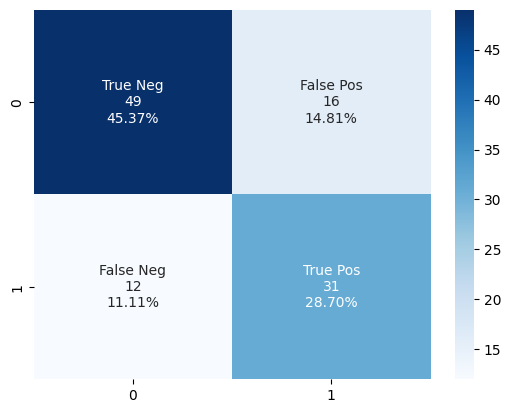

In [16]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
!pip install streamlit
!streamlit hello

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.2 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0



  Welcome to Streamlit. Check out our demo in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.30.167.1:8501

  Ready to create your own Python apps super quickly?
  Head over to https://docs.streamlit.io

  May you create awesome apps!



Streamlit hello
  Stopping...
  Stopping...
Exception ignored in: <module 'threading' from '/usr/lib/python3.12/threading.py'>
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1594, in _shutdown
    atexit_call()
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 31, in _python_exit
    t.join()
  File "/usr/lib/python3.